In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
import seaborn as sns
import micom
from umap import UMAP
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import zscore,pearsonr,ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.stats import wilcoxon
from skbio.diversity import alpha,beta_diversity
from skbio.stats import composition, subsample_counts
from scipy.stats import pearsonr
from tqdm.auto import tqdm as progbar
sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')

In [2]:
def normalize_poscounts(counts):
    """Normalize count matrix. Taxa on columns, samples on rows.
    Uses the poscounts method, meaning that zero sample counts are substituted
    with the n-th root of the geometric mean in all non-zero samples.
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be normalized. Contains variables as columns and
        samples as rows.
    Returns
    -------
    pandas.DataFrame
        A new data frame with normalized samples such that each sample has
        a median log fold change of zero from the reference sample (mean
        of all samples).
    """
    geo_means = counts.apply(lambda x: np.log(x[x > 0]).sum() / len(x), axis=0)

    if not all(np.isfinite(geo_means)):
        raise ValueError("At least one taxa is absent in all samples!")

    print("Normalizing by geometric means.")
    size_factors = counts.apply(lambda x: sample_factors(x, geo_means), axis=1)
    norm_counts = counts.divide(size_factors, axis=0)
    print("Size factor 95%% confidence interval: [%g, %g]" %
                tuple(np.percentile(size_factors.dropna(), [2.5, 97.5])))
    return norm_counts, size_factors


def rarefy_counts(counts, depth=10000):
    """Normalize a count matrix by rarefaction (subsampling).
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be normalized. Contains variables as columns and
        samples as rows.
    Returns
    -------
    pandas.DataFrame
        A new data frame with normalized samples such that each sample has
        a depth of `depth` (sum of variables equals depth).
    """
    print("Subsampling %dx%d count matrix to a depth of %d." %
                (counts.shape[0], counts.shape[1], depth))
    bad = counts.sum(1) < depth
    print("Removing %d samples due to low depth." % bad.sum())
    counts = counts[~bad]
    rare = counts.apply(lambda x: pd.Series(
        subsample_counts(x.astype("int"), depth), index=counts.columns),
        axis=1)
    return rare


def filter_counts(counts, mean=5, presence=0.05):
    """Filter a count matrix for rare taxa.
    Parameters
    ----------
    counts : pandas.DataFrame
        The count matrix to be filtered. Contains variables as columns and
        samples as rows.
    mean : positive float
        The smallest mean count a taxon has to have across all samples.
    presence : float in (0, 1)
        The taxon hast to be present in at least this fraction of samples.
    Returns
    -------
    pandas.DataFrame
        Filtered count matrix with the same rows as `counts` but possibly less
        columns (taxa).
    """
    pre = (counts > 0).mean()
    means = counts.mean()
    good = (pre > presence) & (means > mean)
    print("Filtering count matrix: %d passed, %d removed." %
                (good.sum(), counts.shape[1] - good.sum()))
    return counts.loc[:, good]


In [3]:
#Import data
asvs = pd.read_csv('Weingarden_et_al_asvs.tsv',sep='\t',index_col=0,header=[0,1])
asvs.columns=asvs.columns.droplevel(1)
taxonomy = pd.read_csv('Weingarden_et_al_ncbi-taxonomy.tsv',sep='\t',index_col=0,header=[0,1])
taxonomy.columns=taxonomy.columns.droplevel(1)

depth=1000
rarified=rarefy_counts(asvs,depth=depth)
rarified

Subsampling 149x2342 count matrix to a depth of 1000.
Removing 12 samples due to low depth.


id,fae03a2d8732d0bebc7dd16a6d2789c8,11b4d7e4bcb6bcd8f6d1b27aac33f859,2eca4fca3cea235078cf5ff3142455b5,e7f7014e5cd0b7d19721eec6c9db5d4a,10acc67fb3b2226213bf8f7aa7010097,b0494fa759de2228e3f6b3900949b6a9,ab2268601082058d6f105281c19b29e8,481da41907e61341e0284f55af49f1e8,fb9c4b48fcb5d89827e4d868e63846a8,f3fc3c1992d8118d6105048408aaf6d6,...,9464d49b812d2526a30176e1fe806077,77110cc2f58736d3e769f9c98b2e68ad,f4646cdebb41f815f2a374557cee4895,96ed799d1cf218acc524e133a416cc9e,51bdf5f109ead4338f3b6c866918cf96,70a1b192cb64f383918979bb24b6c6dd,bb781a67fb71df9b394777a54e43a4a3,7e4c284588ef61803f714e9a6afc82cd,294aaac64f2a88856c8dbda8440c29a1,5cb22d9f562b599995bfd2a881025f03
1924.Sadowsky.10,46,72,20,19,77,0,15,42,28,0,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.100,156,29,52,101,11,32,7,33,14,0,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.101,154,19,71,71,26,10,19,27,53,2,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.102,177,7,22,69,30,45,16,24,25,3,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.103,123,8,59,19,23,28,21,23,35,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924.Sadowsky.96,59,49,60,49,35,70,27,19,27,0,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.97,114,51,52,60,18,38,29,12,44,0,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.98,146,1,52,107,34,30,6,39,13,0,...,0,0,0,0,0,0,0,0,0,0
1924.Sadowsky.99,99,48,68,47,33,45,16,22,36,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
genera=[]
for taxon in taxonomy.Taxon:
    if taxon != 'Unassigned':
        d={x.split('__')[0]:x.split('__')[1] for x in taxon.split('; ')}
        if 'g' in d.keys():
            if '[' in d['g']:
                genera.append(d['g'][1:-1])
            else:
                genera.append(d['g'])
        else:
            genera.append('Unclassified')
    else:
        genera.append('Unclassified')
taxonomy['genus']=genera
taxonomy['genus'].to_dict()

{'fae03a2d8732d0bebc7dd16a6d2789c8': 'Phocaeicola',
 '11b4d7e4bcb6bcd8f6d1b27aac33f859': 'Ruminococcus',
 '2eca4fca3cea235078cf5ff3142455b5': 'Eubacterium',
 'e7f7014e5cd0b7d19721eec6c9db5d4a': 'Phocaeicola',
 '10acc67fb3b2226213bf8f7aa7010097': 'Faecalibacterium',
 'b0494fa759de2228e3f6b3900949b6a9': 'Akkermansia',
 'ab2268601082058d6f105281c19b29e8': 'Erysipelatoclostridium',
 '481da41907e61341e0284f55af49f1e8': 'Faecalibacterium',
 'fb9c4b48fcb5d89827e4d868e63846a8': 'Blautia',
 'f3fc3c1992d8118d6105048408aaf6d6': 'Unclassified',
 'f48b96a2ac3575d5febeccd891bfa6e1': 'Bacteroides',
 'c57bf51f33c656b83ae967392536b842': 'Unclassified',
 '8ce638638fc5ee9e2128ac4bd03ed11e': 'Unclassified',
 'b0b7e0684534d30188caff30a7293095': 'Bifidobacterium',
 'afe3fa5345246a89a6e0a1829085b1ca': 'Bacteroides',
 '2f561a0913fb0ed1a03d6cbdd1796e0c': 'Anaerostipes',
 '6e61be427a840557a7cc183eaa91cdc1': 'Dorea',
 'b87a224e8288ae3e76f0d510d4c86f93': 'Barnesiella',
 '68ad65c03501c8130b011b1a7f526046': 'Alisti

In [6]:
genus=rarified.copy()
genus.columns=genus.columns.map(taxonomy['genus'].to_dict())
genus=genus.groupby(level=0,axis=1).sum()
cols=[]
for name in genus.columns:
    newname=''
    for letter in name:
        if letter.isalpha():
            newname+=letter
    cols.append(newname)
    if len(newname) < len(name):
        print(name,newname)
genus.columns=cols
relabund=genus/depth
relabund

,Acetanaerobacterium,Acidaminococcus,Acinetobacter,Actinomyces,Acutalibacter,Adlercreutzia,Aeromonas,Aggregatibacter,Akkermansia,Alistipes,...,Terrisporobacter,Tropheryma,Tumebacillus,Turicibacter,Tyzzerella,Unclassified,Varibaculum,Veillonella,Weissella,Xanthomonas
1924.Sadowsky.10,0.0,0.000,0.000,0.0,0.0,0.001,0.0,0.0,0.000,0.012,...,0.01,0.0,0.0,0.011,0.001,0.035,0.0,0.013,0.0,0.0
1924.Sadowsky.100,0.0,0.007,0.000,0.0,0.0,0.000,0.0,0.0,0.032,0.019,...,0.00,0.0,0.0,0.001,0.001,0.055,0.0,0.000,0.0,0.0
1924.Sadowsky.101,0.0,0.006,0.010,0.0,0.0,0.000,0.0,0.0,0.010,0.025,...,0.00,0.0,0.0,0.000,0.001,0.049,0.0,0.000,0.0,0.0
1924.Sadowsky.102,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.045,0.055,...,0.00,0.0,0.0,0.000,0.000,0.091,0.0,0.000,0.0,0.0
1924.Sadowsky.103,0.0,0.039,0.001,0.0,0.0,0.000,0.0,0.0,0.028,0.020,...,0.00,0.0,0.0,0.000,0.000,0.063,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924.Sadowsky.96,0.0,0.006,0.000,0.0,0.0,0.000,0.0,0.0,0.070,0.035,...,0.00,0.0,0.0,0.000,0.001,0.079,0.0,0.000,0.0,0.0
1924.Sadowsky.97,0.0,0.005,0.000,0.0,0.0,0.000,0.0,0.0,0.038,0.040,...,0.00,0.0,0.0,0.000,0.001,0.038,0.0,0.000,0.0,0.0
1924.Sadowsky.98,0.0,0.002,0.000,0.0,0.0,0.000,0.0,0.0,0.030,0.035,...,0.00,0.0,0.0,0.000,0.001,0.044,0.0,0.000,0.0,0.0
1924.Sadowsky.99,0.0,0.009,0.002,0.0,0.0,0.000,0.0,0.0,0.045,0.021,...,0.00,0.0,0.0,0.002,0.002,0.053,0.0,0.001,0.0,0.0


Text(0.5, 0, 'Unknown fraction')

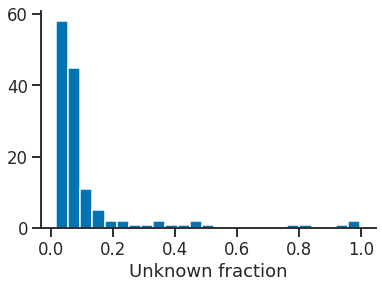

In [7]:
x=(genus['Unclassified']/genus.sum(axis=1)).values
hist=plt.hist(x,bins=25)
plt.xlabel('Unknown fraction')

In [8]:
def reduce_group(df):
    new = df.iloc[0, :]
    new["file"] = "|".join(df.id.apply(lambda id: f"{id}.xml"))
    return new

'''
data = unprocessed dataframe
'''
def merge(data,agora,level='genus'):
    keep = ["samples","kingdom","phylum","class","order","family","genus","oxygenstat","metabolism","gram","mtype","genes","file","reads","relative"]
    group = data.groupby(["id", level]).sum().reset_index()
    merge = pd.merge(group, agora, on=level, suffixes=["_x", ""])
    merge['samples'] = merge['id_x']
    merge = merge[keep]
    return merge

'''
data   = dataframe after agora merge
prefix = sample prefix
'''
def invade(data, prefix, rel,level='genus'):
    genus_df = pd.DataFrame(columns = data.columns)
    
    for index,sample in data.groupby(by='samples'):
        reads = ((sample['reads'].sum() / (1.0 - rel) - sample['reads'].sum()))
        cdiff['reads'] = reads.round()
        cdiff['samples'] = str(index)
        cdiff['relative'] = reads / (sample['reads'].sum() + reads)
        sample = sample.append(cdiff)
        genus_df = genus_df.append(sample)    
    genus_df['samples'] = genus_df['samples'].astype(str)
    genus_df = genus_df.reset_index(drop=True)
    return genus_df

In [9]:
keep = ["samples","kingdom","phylum","class","order","family","genus","oxygenstat","metabolism","gram","mtype","genes","file","reads","relative"]
agora=pd.read_csv('../../arivale/agora103_genus.csv')

cdiff = agora[agora.genus=='Clostridioides']
for column in cdiff.columns:
    if column not in keep:
        cdiff = cdiff.drop(column, axis=1).copy()
agora = agora[agora.genus!='Clostridioides']
agora

,organism,seedid,oxygenstat,metabolism,gram,mtype,genes,reactions,metabolites,draftcreator,...,phylum,class,order,family,genus,species,file,kbaseid,id,summary_rank
0,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva ATCC 49176 (592010.4),Facultative anaerobe,"Saccharolytic, fermentative or respiratory",Positive,Pathogen,631.0,2428.0,1250.0,Eugen Bauer,...,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,Abiotrophia.json,NaN,Abiotrophia,genus
1,Clostridium sticklandii DSM 519,Clostridium sticklandii DSM 519 (499177.3),Obligate anaerobe,"Proteolytic, non-sachharolytic",Positive,NaN,699.0,1270.0,959.0,Laura Kutt,...,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Acetoanaerobium,Acetoanaerobium sticklandii,Acetoanaerobium.json,kb|g.1828,Acetoanaerobium,genus
2,"Anaerobaculum hydrogeniformans OS1, ATCC BAA-1850",Anaerobaculum hydrogeniformans ATCC BAA-1850 (...,Obligate anaerobe,"Saccharolytic, fermentative",Negative,Commensal,670.0,1030.0,825.0,Ines Thiele,...,Synergistetes,Synergistia,Synergistales,Synergistaceae,Acetomicrobium,Acetomicrobium hydrogeniformans,Acetomicrobium.json,NaN,Acetomicrobium,genus
3,NaN,Achromobacter xylosoxidans A8 (762376.5),Aerobe,Respiratory,Negative,NaN,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Achromobacter xylosoxidans,Achromobacter.json,NaN,Achromobacter,genus
4,NaN,NaN,Obligate anaerobe,NaN,Negative,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,NaN,Acidaminococcus.json,kb|g.2555,Acidaminococcus,genus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,NaN,Obligate anaerobe,NaN,NaN,NaN,NaN,NaN,NaN,Ines Thiele,...,Firmicutes,Clostridia,Clostridiales,unclassified Clostridiales family,unclassified Clostridiales genus,NaN,unclassified_Clostridiales_genus.json,NaN,unclassified_Clostridiales_genus,genus
257,Enterobacteriaceae bacterium 9_2_54FAA,Enterobacteriaceae bacterium 9_2_54FAA (469613.3),Aerobe,Uncharacterized,Uncharacterized,Uncharacterized,1177.0,2209.0,1422.0,Ines Thiele,...,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,unclassified Enterobacteriaceae genus,Enterobacteriaceae bacterium 9_2_54FAA,unclassified_Enterobacteriaceae_genus.json,NaN,unclassified_Enterobacteriaceae_genus,genus
258,NaN,NaN,Obligate anaerobe,Uncharacterized,Uncharacterized,Uncharacterized,NaN,NaN,NaN,Ines Thiele,...,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,unclassified Erysipelotrichaceae genus,NaN,unclassified_Erysipelotrichaceae_genus.json,NaN,unclassified_Erysipelotrichaceae_genus,genus
259,NaN,NaN,Obligate anaerobe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,unclassified Lachnospiraceae genus,NaN,unclassified_Lachnospiraceae_genus.json,NaN,unclassified_Lachnospiraceae_genus,genus


In [10]:
#Present
strains=['Anaerotruncus colihominis',
'Clostridium bolteae',
'Blautia producta',
'Dorea longicatena',
'Clostridium innocuum',
'Flavonifractor plautii']
#Absent
'Sellinimonas intestinalis'
'Clostridium symbiosum'

species=pd.read_csv('../../agora_species/agora103_species.csv')
idx=species.organism.dropna().index
species=species.loc[idx]


probiotic = pd.DataFrame()
for s in strains:
    df=species[species.organism.str.contains(s)]
    probiotic=pd.concat([probiotic,df])
probiotic

,organism,kingdom,phylum,class,order,family,genus,oxygenstat,metabolism,gram,...,species,file,ncbiid,kbaseid,seedid,taxa_id,imgid,phenotype,id,summary_rank
127,Anaerotruncus colihominis DSM 17241,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Anaerotruncus,Obligate anaerobe,"Saccharolytic, fermentative",Positive,...,colihominis,colihominis.json,445972.0,NaN,Anaerotruncus colihominis DSM 17241 (445972.6),169435.0,6.417363e+08,4.0,colihominis,species
70,Clostridium bolteae ATCC BAA-613,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,Obligate anaerobe,"Saccharolytic, fermentative",Positive,...,bolteae,bolteae.json,411902.0,NaN,Clostridium bolteae ATCC BAA-613 (411902.9),208479.0,6.413804e+08,5.0,bolteae,species
431,Blautia producta DSM 2950,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,Obligate anaerobe,"Saccharolytic, fermentative, hydrogen used as ...",Positive,...,producta,producta.json,1121114.0,kb|g.29565,NaN,33035.0,NaN,NaN,producta,species
320,Dorea longicatena DSM 13814,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Dorea,Obligate anaerobe,"Saccharolytic, fermentative",Positive,...,longicatena,longicatena.json,411462.0,NaN,Dorea longicatena DSM 13814 (411462.6),88431.0,6.409630e+08,3.0,longicatena,species
285,Clostridium innocuum 2959,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Erysipelatoclostridium,Obligate anaerobe,"Saccharolytic, fermentative",Negative,...,innocuum,innocuum.json,999413.0,kb|g.32468,Clostridium innocuum 2959 (999413.4),NaN,2.534682e+09,NaN,innocuum,species
423,Flavonifractor plautii ATCC 29863,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Flavonifractor,Facultative anaerobe,"Saccharolytic, respiratory or fermentative",Positive,...,plautii,plautii.json,411475.0,kb|g.26645,NaN,292800.0,2.513237e+09,NaN,plautii,species


(-0.05, 1.05)

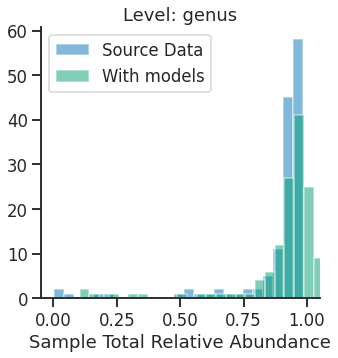

In [11]:
cdiff_rel=0.1
#df=genus['Unclassified']/genus.sum(axis=1)
#idx=df[df<.3].index.values
temp = relabund.copy()
temp=temp.drop('Unclassified',axis=1)
temp = temp.stack().reset_index()
temp.columns = ['id','genus','relative']
temp=temp[temp['relative']>=10**-3]
temp['reads'] = temp['relative']*depth
x1=temp.groupby(by='id')['relative'].sum().values
plt.figure(figsize=(5,5))
hist=plt.hist(x1,bins=25,label='Source Data',alpha=.5)
plt.xlabel('Sample Total Relative Abundance')
temp_model = merge(temp,agora,level='genus')
temp_genera = invade(temp_model,"",cdiff_rel,level='genus')
#temp_genera.to_csv('CDI_%s_micom-%s-cdiff.csv'%('genus',cdiff_rel))
#temp_genera[temp_genera['genus']!='Clostridioides'].to_csv('CDI_%s_micom-no-cdiff.csv'%('genus'))
x2=temp_genera.groupby(by='samples')['relative'].sum().values
hist=plt.hist(x2,bins=25,label='With models',alpha=0.5,color='g')
plt.title('Level: %s'%'genus')
plt.legend()
plt.xlim(-.05,1.05)
#plt.savefig('Model_abund_dist-gg.png',dpi=500,bbox_inches='tight')

In [12]:
def inject_probiotic(data,strains, prefix,prob_rel,cdiff_rel):
    genus_df = pd.DataFrame(columns = data.columns)

    for index,sample in data.groupby(by='samples'):
        reads = ((sample['reads'].sum() / (1.0 - (prob_rel+cdiff_rel)) - sample['reads'].sum()))
        
        cdiff_reads=reads/((prob_rel+cdiff_rel)/cdiff_rel)
        cdiff['reads'] = cdiff_reads
        cdiff['samples'] = str(index)
        cdiff['relative'] = cdiff_reads/(sample['reads'].sum() + reads)
        if prob_rel != 0:
            strain_reads=reads/((prob_rel+cdiff_rel)/(prob_rel)*len(strains))
        else:
            strain_reads=0
        strains['reads'] = strain_reads
        strains['samples'] = str(index)
        strains['relative'] = strain_reads/(sample['reads'].sum() + reads)

        sample = sample.append(cdiff)
        sample = sample.append(strains)
        genus_df = genus_df.append(sample)    
        
    genus_df['samples'] = genus_df['samples'].astype(str)
    genus_df = genus_df.reset_index(drop=True)
    return genus_df

def vancomycin_treatment(data,frac=0.9,strains=['Roseburia','Coprococcus','Ruminococcus','Blautia','Dorea','Faecalibacterium','Oscillospira','Clostridium','Bacteroides','Staphylococcus','Fusobacterium','Megasphaera','Veillonella']):
    genus_df = pd.DataFrame(columns = data.columns)

    for index,sample in temp_model.groupby(by='samples'):
        idx=sample[sample.genus.isin(strains)].index
        sample.loc[idx,'reads']=sample.loc[idx,'reads']*(1-frac)
        sample['relative']=sample['reads']/sample['reads'].sum()
        genus_df = genus_df.append(sample)    
    return genus_df

In [13]:
cdiff_lvl=0.1
prob_lvl=0

treatment=vancomycin_treatment(temp_model)
test=inject_probiotic(treatment,probiotic,'',prob_lvl,cdiff_lvl)
#test.to_csv('CDI_%s_micom-%s-cdiff-%s-probiotic-vanco.csv'%('genus',cdiff_lvl,prob_lvl))
#test[test['genus']!='Clostridioides'].to_csv('CDI_%s_micom-no-cdiff-%s-probiotic-vanco.csv'%('genus',prob_lvl))
test

,samples,kingdom,phylum,class,order,family,genus,oxygenstat,metabolism,gram,...,platform,species,ncbiid,kbaseid,seedid,taxa_id,imgid,phenotype,id,summary_rank
0,1924.Sadowsky.10,Bacteria,Actinobacteria,Coriobacteriia,Eggerthellales,Eggerthellaceae,Adlercreutzia,Obligate anaerobe,"Asaccharolytic, nonfermentative",Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1924.Sadowsky.10,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Obligate anaerobe,NaN,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1924.Sadowsky.10,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Anaerobutyricum,Obligate anaerobe,NaN,Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1924.Sadowsky.10,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Anaerostipes,Obligate anaerobe,NaN,Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1924.Sadowsky.10,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN,"Saccharolytic, fermentative",Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,1924.Sadowsky.9r,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,Obligate anaerobe,"Saccharolytic, fermentative",Positive,...,ModelSEED,bolteae,411902.0,NaN,Clostridium bolteae ATCC BAA-613 (411902.9),208479.0,6.413804e+08,5.0,bolteae,species
4631,1924.Sadowsky.9r,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,Obligate anaerobe,"Saccharolytic, fermentative, hydrogen used as ...",Positive,...,ModelSEED,producta,1121114.0,kb|g.29565,NaN,33035.0,NaN,NaN,producta,species
4632,1924.Sadowsky.9r,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Dorea,Obligate anaerobe,"Saccharolytic, fermentative",Positive,...,ModelSEED,longicatena,411462.0,NaN,Dorea longicatena DSM 13814 (411462.6),88431.0,6.409630e+08,3.0,longicatena,species
4633,1924.Sadowsky.9r,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Erysipelatoclostridium,Obligate anaerobe,"Saccharolytic, fermentative",Negative,...,Kbase,innocuum,999413.0,kb|g.32468,Clostridium innocuum 2959 (999413.4),NaN,2.534682e+09,NaN,innocuum,species


In [14]:
meta=pd.read_csv('meta.txt',sep='\t')
growth_rates=pd.read_pickle('Weingarden_et_al_+cdiff_growth_rates_tradeoff_pfba.pkl')
growth_rates=growth_rates.reset_index()

growth_data=pd.merge(meta,growth_rates,left_on='sample_name',right_on='sample')
growth_data['log_growth']=np.log10(growth_data['growth_rate'])
counts=growth_data.pivot_table(index='sample',columns='compartments',values='abundance').fillna(0)*100000
counts=counts.astype(int)
shannon={}
for i in counts.index:
    shannon[i]=alpha.shannon(counts.loc[i,:].values)
growth_data['shannon']=growth_data['sample'].map(shannon)
growth_data

,sample_name,animations_gradient,animations_subject,anonymized_name,collection_timestamp,day_relative_to_fmt,description,disease_state,dna_extracted,elevation,...,taxon_id,title,tot_mass,compartments,growth_rate,abundance,sample,tradeoff,log_growth,shannon
0,1924.Sadowsky.10,8,CD1,Sadowsky.10,2011-08-03,8,Day 8 CD1,post-FMT,True,440.82907,...,408170,sadowsky_CDdiff_transplants,80.1,Alistipes,3.155789e-01,0.018124,1924.Sadowsky.10,0.8,-0.500892,2.978123
1,1924.Sadowsky.10,8,CD1,Sadowsky.10,2011-08-03,8,Day 8 CD1,post-FMT,True,440.82907,...,408170,sadowsky_CDdiff_transplants,80.1,Anaerobutyricum,6.040286e-02,0.021322,1924.Sadowsky.10,0.8,-1.218943,2.978123
2,1924.Sadowsky.10,8,CD1,Sadowsky.10,2011-08-03,8,Day 8 CD1,post-FMT,True,440.82907,...,408170,sadowsky_CDdiff_transplants,80.1,Anaerostipes,1.435212e-02,0.004264,1924.Sadowsky.10,0.8,-1.843084,2.978123
3,1924.Sadowsky.10,8,CD1,Sadowsky.10,2011-08-03,8,Day 8 CD1,post-FMT,True,440.82907,...,408170,sadowsky_CDdiff_transplants,80.1,Bacteroides,2.888988e-01,0.036247,1924.Sadowsky.10,0.8,-0.539254,2.978123
4,1924.Sadowsky.10,8,CD1,Sadowsky.10,2011-08-03,8,Day 8 CD1,post-FMT,True,440.82907,...,408170,sadowsky_CDdiff_transplants,80.1,Barnesiella,1.113091e-01,0.006397,1924.Sadowsky.10,0.8,-0.953469,2.978123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,1924.Sadowsky.9r,49,Donor,Sadowsky.9r,2011-09-13,49,Donor 10,healthy,True,440.82907,...,408170,sadowsky_CDdiff_transplants,Restricted access,Phocaeicola,4.331316e-01,0.151087,1924.Sadowsky.9r,0.8,-0.363380,2.712145
3284,1924.Sadowsky.9r,49,Donor,Sadowsky.9r,2011-09-13,49,Donor 10,healthy,True,440.82907,...,408170,sadowsky_CDdiff_transplants,Restricted access,Pseudoflavonifractor,8.446225e-07,0.002174,1924.Sadowsky.9r,0.8,-6.073337,2.712145
3285,1924.Sadowsky.9r,49,Donor,Sadowsky.9r,2011-09-13,49,Donor 10,healthy,True,440.82907,...,408170,sadowsky_CDdiff_transplants,Restricted access,Roseburia,1.417474e-06,0.013043,1924.Sadowsky.9r,0.8,-5.848485,2.712145
3286,1924.Sadowsky.9r,49,Donor,Sadowsky.9r,2011-09-13,49,Donor 10,healthy,True,440.82907,...,408170,sadowsky_CDdiff_transplants,Restricted access,Ruminococcus,2.175498e-03,0.014130,1924.Sadowsky.9r,0.8,-2.662441,2.712145


Ttest_indResult(statistic=-3.371287086796906, pvalue=0.0021993211525314295)


/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0, 0.5, 'log $C. diff$ growth')

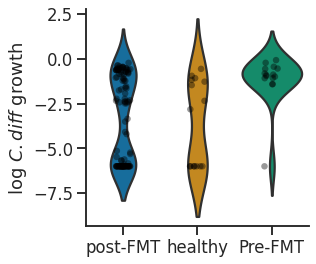

In [15]:
fig,ax=plt.subplots(figsize=(4,4))
df=growth_data[growth_data.compartments=='Clostridioides']
df['day_relative_to_fmt']=[int(x) if x != 'pre-FMT' else 0 for x in df['day_relative_to_fmt']]
idx=df[df['log_growth']<-6].index
df.loc[idx,'log_growth']=-6
sns.violinplot(x='disease_state',y='log_growth',data=df, inner=None, ax=ax) 
ax=sns.stripplot(x='disease_state',y='log_growth',color='black', size=6.5, data=df, ax=ax,alpha=0.4)

# This is the part about the colormap
#cmap = plt.get_cmap("viridis")
#norm = plt.Normalize(df['day_relative_to_fmt'].min(),df['day_relative_to_fmt'].max())
#sm =  ScalarMappable(norm=norm, cmap=cmap)
#sm.set_array([])
#cbar = fig.colorbar(sm, ax=ax)
#cbar.ax.set_title("Days relative\nto FMT")

#remove the legend created by seaborn
#ax.legend_.remove()
x1=df[df.disease_state=='healthy']['log_growth']
x2=df[df.disease_state=='Pre-FMT']['log_growth']

print(ttest_ind(x1,x2))
plt.xlabel('')
plt.ylabel('log $C. diff$ growth')
#plt.savefig('CDI-FMT-violins-v2.pdf',bbox_inches='tight')

In [288]:
#pre-FMT vs post-FMT 0.001
#healthy vs post-FMT 0.62
#healthy vs Pre-FMT 0.002
x1=df[df.disease_state=='Pre-FMT']['log_growth']
x2=df[df.disease_state=='post-FMT']['log_growth']

print(ttest_ind(x1,x2,equal_var=False))

Ttest_indResult(statistic=4.887159878756644, pvalue=3.895745734293097e-05)


Text(0.5, 0, '')

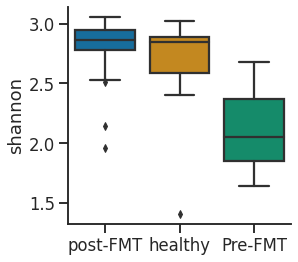

In [16]:
plt.figure(figsize=(4,4))
df=growth_data[growth_data.compartments=='Clostridioides']

sns.boxplot(x='disease_state',y='shannon',data=df)

x1=df[df.disease_state=='Pre-FMT']['shannon']
x2=df[df.disease_state=='healthy']['shannon']

ttest_ind(x1,x2,equal_var=False)
plt.xlabel('')

Text(0, 0.5, 'log $C. diff$ growth')

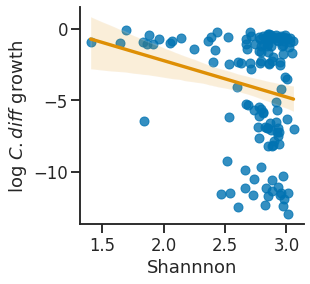

In [17]:
fig,ax=plt.subplots(figsize=(4,4))
sns.regplot(x='shannon',y='log_growth',data=df,fit_reg=False)
sns.regplot(x='shannon',y='log_growth',data=df,scatter=False)
plt.xlabel('Shannnon')
plt.ylabel('log $C. diff$ growth')
#plt.savefig('FMT-log-cdiff-vs-shannon.pdf',bbox_inches='tight')

In [18]:
df['intercept']=1
lm=ols('log_growth~shannon+intercept',data=df).fit()
lm.summary()

/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_growth   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.922
Date:                Tue, 02 May 2023   Prob (F-statistic):             0.0163
Time:                        16:51:24   Log-Likelihood:                -376.67
No. Observations:                 136   AIC:                             757.3
Df Residuals:                     134   BIC:                             763.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4313      1.438      0.995      0.322      -1.414       4.276
shannon       -2.5412      1.044     -2.434      0.016      -4.606      -0.476
intercept      1.4313      1.438      0.995      0.322      -1.414       4.276
==============================================================================
Omnibus:                       17.744   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.667
Skew:                          -0.747   Prob(JB):                     0.000396
Kurtosis:                       2.269   Cond. No.                     3.09e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

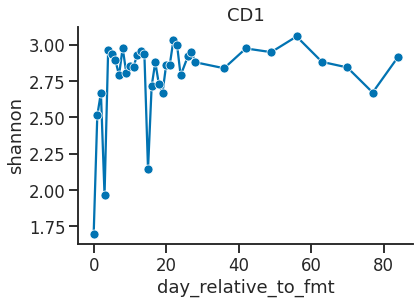

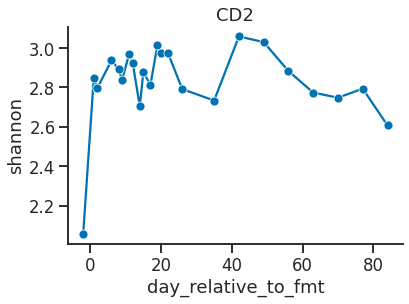

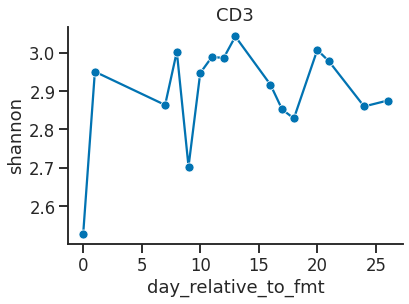

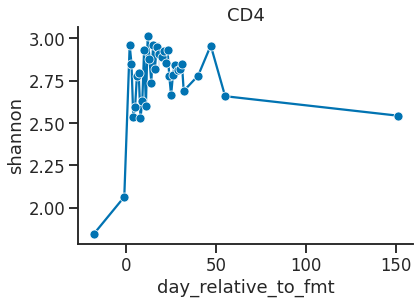

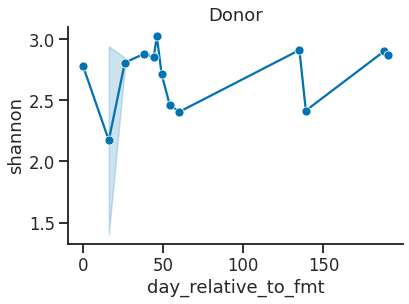

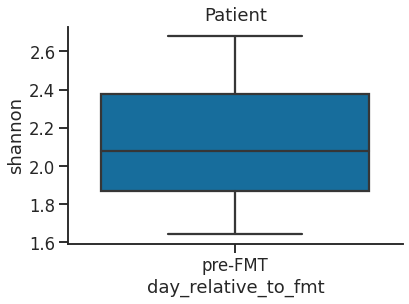

<Figure size 432x288 with 0 Axes>

In [19]:
for idx,df in growth_data[growth_data.compartments=='Clostridioides'].groupby(by='animations_subject'):
    try:
        df.day_relative_to_fmt=df.day_relative_to_fmt.astype(int)
        g=sns.lineplot(x='day_relative_to_fmt',y='shannon',data=df,marker='o')
        #plt.plot(g.get_xlim(),(-6,-6),'k--')
    except:
        sns.boxplot(x='day_relative_to_fmt',y='shannon',data=df)
    
    plt.title(idx)
    #plt.ylim(-10,0)
    plt.show()
    plt.clf()

In [20]:
fluxes=pd.read_pickle('Weingarden_et_al_no-cdiff_fluxes_tradeoff_pfba.pkl')
fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in growth_rates[['sample','compartments']].values])
fluxes=fluxes.fillna(10**-6).drop('sample',axis=1)
exchanges=fluxes[fluxes.columns[['EX_' in x for x in fluxes.columns ]]]
exchanges

reaction                                  EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.14r Akkermansia               1.000000e-06       0.000001   
                  Clostridioides           -6.199469e-03       0.000001   
                  Clostridium              -1.573171e-04       0.000001   
                  Erysipelatoclostridium   -6.338045e-04       0.000001   
                  Fusobacterium             1.000000e-06       0.000001   
...                                                  ...            ...   
1924.Sadowsky.99  Phocaeicola               1.000000e-06       0.000001   
                  Roseburia                -4.467107e-07       0.000001   
                  Ruminococcus             -1.678608e-06       0.000001   
                  Streptococcus            -6.872225e-06       0.000001   
                  community                 1.000000e-06      -0.000381   

reaction                                  EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.14r Akkermansia                   0.000001   1.000000e-06   
                  Clostridioides                0.000001   1.000000e-06   
                  Clostridium                  -0.391226   1.000000e-06   
                  Erysipelatoclostridium        5.856227   1.000000e-06   
                  Fusobacterium                 0.000001   1.000000e-06   
...                                                  ...            ...   
1924.Sadowsky.99  Phocaeicola                   0.000001   1.000000e-06   
                  Roseburia                     0.000001   1.000000e-06   
                  Ruminococcus                  0.000105   1.000000e-06   
                  Streptococcus                 0.000001   1.000000e-06   
                  community                     0.000001   1.910192e-07   

reaction                                  EX_12ppd_S(e)  EX_12ppd_S_m  \
1924.Sadowsky.14r Akkermansia                 -2.392333      0.000001   
                  Clostridioides               0.000001      0.000001   
                  Clostridium                 45.040788      0.000001   
                  Erysipelatoclostridium       0.000001      0.000001   
                  Fusobacterium                0.000001      0.000001   
...                                                 ...           ...   
1924.Sadowsky.99  Phocaeicola                  0.000055      0.000001   
                  Roseburia                   -0.000040      0.000001   
                  Ruminococcus                -0.000073      0.000001   
                  Streptococcus                0.000001      0.000001   
                  community                    0.000001      0.000004   

reaction                                  EX_13ppd(e)    EX_13ppd_m  \
1924.Sadowsky.14r Akkermansia                0.000001  1.000000e-06   
                  Clostridioides            -0.000000  1.000000e-06   
                  Clostridium                1.127033  1.000000e-06   
                  Erysipelatoclostridium     0.000001  1.000000e-06   
                  Fusobacterium              0.000001  1.000000e-06   
...                                               ...           ...   
1924.Sadowsky.99  Phocaeicola                0.000001  1.000000e-06   
                  Roseburia                  0.000001  1.000000e-06   
                  Ruminococcus               0.000001  1.000000e-06   
                  Streptococcus              0.000001  1.000000e-06   
                  community                  0.000001  8.417652e-07   

reaction                                  EX_15dap(e)    EX_15dap_m  ...  \
1924.Sadowsky.14r Akkermansia                0.000001  1.000000e-06  ...   
                  Clostridioides             0.000001  1.000000e-06  ...   
                  Clostridium                0.056810  1.000000e-06  ...   
                  Erysipelatoclostridium     0.000001  1.000000e-06  ...   
                  Fusobacterium              0.440389  1.000000e-06  ...   
...         

In [21]:
export_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
export_flux[export_flux<=0]=10**-6
export_flux=np.log10(export_flux)
export_flux[export_flux<-6]=-6
export_flux

import_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
import_flux[import_flux >=0]=10**-6
import_flux=abs(import_flux)
import_flux=np.log10(import_flux)
import_flux=import_flux[import_flux>-6].fillna(-6)
import_flux

reaction                                  EX_12dgr180(e)  EX_12dgr180_m  \
1924.Sadowsky.14r Akkermansia                  -6.000000           -6.0   
                  Clostridioides               -2.207646           -6.0   
                  Clostridium                  -3.803224           -6.0   
                  Erysipelatoclostridium       -3.198045           -6.0   
                  Fusobacterium                -6.000000           -6.0   
...                                                  ...            ...   
1924.Sadowsky.99  Parasutterella               -6.000000           -6.0   
                  Phocaeicola                  -6.000000           -6.0   
                  Roseburia                    -6.000000           -6.0   
                  Ruminococcus                 -5.775051           -6.0   
                  Streptococcus                -5.162903           -6.0   

reaction                                  EX_12dhchol(e)  EX_12dhchol_m  \
1924.Sadowsky.14r Akkermansia                  -6.000000           -6.0   
                  Clostridioides               -6.000000           -6.0   
                  Clostridium                  -0.407573           -6.0   
                  Erysipelatoclostridium       -6.000000           -6.0   
                  Fusobacterium                -6.000000           -6.0   
...                                                  ...            ...   
1924.Sadowsky.99  Parasutterella               -6.000000           -6.0   
                  Phocaeicola                  -6.000000           -6.0   
                  Roseburia                    -6.000000           -6.0   
                  Ruminococcus                 -6.000000           -6.0   
                  Streptococcus                -6.000000           -6.0   

reaction                                  EX_12ppd_S(e)  EX_12ppd_S_m  \
1924.Sadowsky.14r Akkermansia                  0.378822          -6.0   
                  Clostridioides              -6.000000          -6.0   
                  Clostridium                 -6.000000          -6.0   
                  Erysipelatoclostridium      -6.000000          -6.0   
                  Fusobacterium               -6.000000          -6.0   
...                                                 ...           ...   
1924.Sadowsky.99  Parasutterella              -6.000000          -6.0   
                  Phocaeicola                 -6.000000          -6.0   
                  Roseburia                   -4.402353          -6.0   
                  Ruminococcus                -4.136337          -6.0   
                  Streptococcus               -6.000000          -6.0   

reaction                                  EX_13ppd(e)  EX_13ppd_m  \
1924.Sadowsky.14r Akkermansia                    -6.0        -6.0   
                  Clostridioides                 -6.0        -6.0   
                  Clostridium                    -6.0        -6.0   
                  Erysipelatoclostridium         -6.0        -6.0   
                  Fusobacterium                  -6.0        -6.0   
...                                               ...         ...   
1924.Sadowsky.99  Parasutterella                 -6.0        -6.0   
                  Phocaeicola                    -6.0        -6.0   
                  Roseburia                      -6.0        -6.0   
                  Ruminococcus                   -6.0        -6.0   
                  Streptococcus                  -6.0        -6.0   

reaction                                  EX_15dap(e)  EX_15dap_m  ...  \
1924.Sadowsky.14r Akkermansia                    -6.0        -6.0  ...   
                  Clostridioides                 -6.0        -6.0  ...   
                  Clostridium                    -6.0        -6.0  ...   
                  Erysipelatoclostridium         -6.0        -6.0  ...   
                  Fusobacterium                  -6.0        -6.0  ...   
...                                             

In [22]:
import_med = exchanges.copy()[[x[1] == 'community' for x in exchanges.index]]
import_med[import_med<=0]=10**-6
import_med=np.log10(import_med)
import_med.index=import_med.index.droplevel(1)
import_med

export_med = exchanges.copy()[[x[1] == 'community' for x in exchanges.index]]
export_med[export_med >=0]=10**-6
export_med=abs(export_med)
export_med=np.log10(export_med)
export_med.index=export_med.index.droplevel(1)
export_med

reaction,EX_12dgr180(e),EX_12dgr180_m,EX_12dhchol(e),EX_12dhchol_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13ppd(e),EX_13ppd_m,EX_15dap(e),EX_15dap_m,...,EX_fald(e),EX_fald_m,EX_hco3(e),EX_hco3_m,EX_sbt_L(e),EX_sbt_L_m,EX_3hcinnm(e),EX_3hcinnm_m,EX_3hpppn(e),EX_3hpppn_m
1924.Sadowsky.14r,-6.0,-3.239055,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.15r,-6.0,-7.793765,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.12r,-6.0,-3.737078,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.111,-6.0,-3.639079,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.13r,-6.0,-4.604543,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924.Sadowsky.96,-6.0,-3.760986,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.82,-6.0,-2.792371,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.9r,-6.0,-3.971227,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
1924.Sadowsky.98,-6.0,-3.454937,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0


In [22]:
import_med=import_med[import_med>-6].fillna(-6)
cols=import_med.columns[import_med.mean(axis=0)>-6]

umap = UMAP()
df=import_med[cols].copy()
fit= umap.fit(df)
coord =fit.embedding_
umap_imprt=pd.DataFrame(coord)
umap_imprt.columns=['x','y']
umap_imprt.index=import_med.index
umap_imprt


,x,y
1924.Sadowsky.14r,-2.686991,8.820465
1924.Sadowsky.15r,4.087526,8.256085
1924.Sadowsky.12r,2.923374,8.650294
1924.Sadowsky.111,7.193293,8.095779
1924.Sadowsky.13r,5.243784,7.890853
...,...,...
1924.Sadowsky.96,4.997405,7.759761
1924.Sadowsky.82,-1.751465,8.993587
1924.Sadowsky.9r,4.037420,6.078969
1924.Sadowsky.98,3.216028,6.674979


/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Community Import Fluxes')

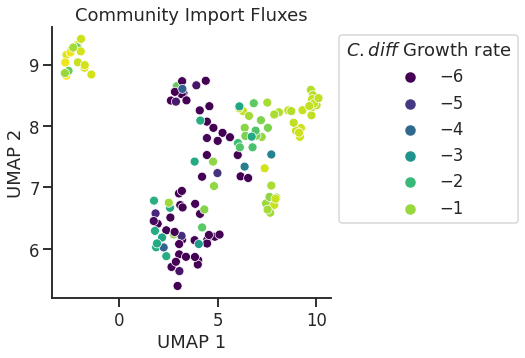

In [30]:
plt.figure(figsize=(5,5))
df=umap_imprt
hue=growth_rates[(growth_rates.compartments=='Clostridioides')][['growth_rate','sample','compartments']]
hue.index=hue['sample']
hue=hue.loc[umap_imprt.index]
hue=np.log10(hue['growth_rate'])
idx=hue[hue<-6].index.values
hue[idx]=-6
sns.scatterplot(df['x'],df['y'],hue=hue,palette='viridis')
plt.legend(bbox_to_anchor=(1,1),title='$C.diff$ Growth rate')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Community Import Fluxes')

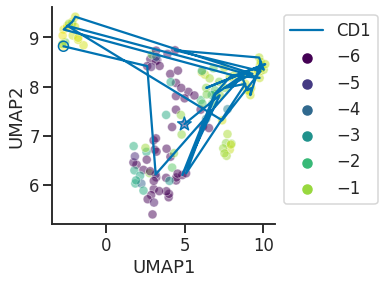

<Figure size 432x288 with 0 Axes>

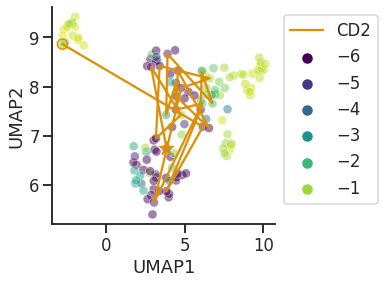

<Figure size 432x288 with 0 Axes>

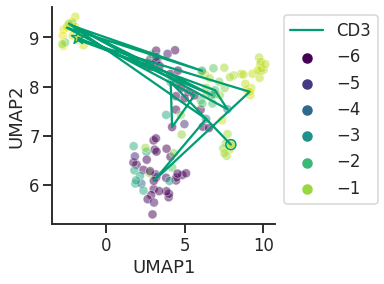

<Figure size 432x288 with 0 Axes>

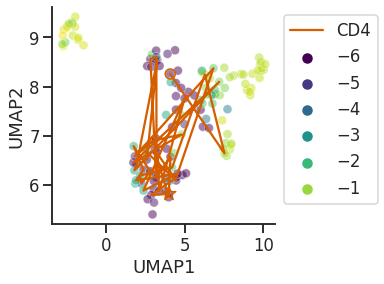

<Figure size 432x288 with 0 Axes>

In [40]:
temp=pd.merge(growth_data[(growth_data.compartments=='Clostridioides')],umap_imprt.reset_index(),left_on='sample_name',right_on='index')
idx=temp[temp.log_growth<-6].index.values
temp.loc[idx,'log_growth']=-6
colors=sns.color_palette('colorblind')
i=0
for idx,df in temp.groupby(by='animations_subject'):
    if 'CD' not in idx:
        continue
    plt.figure(figsize=(4,4))
    df=df.sort_values(by='collection_timestamp')
    sns.scatterplot(x='x',y='y',hue='log_growth',data=temp,alpha=0.5,palette='viridis')
    plt.plot(df['x'],df['y'],label=idx,color=colors[i])
    plt.scatter(df['x'].values[0],df['y'].values[0],marker='o',color=colors[i],s=100,edgecolors=colors[i],facecolors='none')
    plt.scatter(df['x'].values[-1],df['y'].values[-1],marker='*',color=colors[i],s=200,edgecolors=colors[i],facecolors='none')
    i+=1
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    #plt.savefig('%s-export-trajectory-UMAP.pdf'%(idx),bbox_inches='tight')
    plt.show()
    plt.clf()

In [23]:
fluxes=pd.read_pickle('Weingarden_et_al_+cdiff_fluxes_tradeoff_pfba.pkl')
fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in growth_rates[['sample','compartments']].values])
fluxes=fluxes.fillna(10**-6).drop('sample',axis=1)
exchanges=fluxes[fluxes.columns[['EX_' in x for x in fluxes.columns ]]]
export_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
export_flux[export_flux<=0]=10**-6
export_flux=np.log10(export_flux)
export_flux[export_flux<-6]=-6
export_flux

import_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
import_flux[import_flux >=0]=10**-6
import_flux=abs(import_flux)
import_flux=np.log10(import_flux)
import_flux=import_flux[import_flux>-6].fillna(-6)
import_flux

imprts=import_flux.reset_index()
imprts=imprts[imprts.level_1=='Clostridioides']
cdiff_rate=growth_rates[growth_rates.compartments=='Clostridioides']
cdiff_import=pd.merge(imprts,cdiff_rate,left_on='level_0',right_on='sample')
cdiff_import=cdiff_import.drop(['level_0','level_1'],axis=1)
cdiff_import['log_growth']=np.log10(cdiff_import.growth_rate)
cdiff_import

,EX_12dgr180(e),EX_12dgr180_m,EX_12dhchol(e),EX_12dhchol_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13ppd(e),EX_13ppd_m,EX_15dap(e),EX_15dap_m,...,EX_3hcinnm(e),EX_3hcinnm_m,EX_3hpppn(e),EX_3hpppn_m,compartments,growth_rate,abundance,sample,tradeoff,log_growth
0,-2.207646,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,8.368364e-01,0.099844,1924.Sadowsky.14r,0.8,-0.077359
1,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,3.800861e-07,0.100678,1924.Sadowsky.15r,0.8,-6.420118
2,-2.988072,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,3.372752e-02,0.099903,1924.Sadowsky.12r,0.8,-1.472016
3,-2.926217,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,5.840250e-02,0.100727,1924.Sadowsky.111,0.8,-1.233569
4,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,3.223110e-07,0.100671,1924.Sadowsky.13r,0.8,-6.491725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,1.091756e-13,0.100320,1924.Sadowsky.96,0.8,-12.961875
132,-2.356408,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,3.506263e-01,0.100956,1924.Sadowsky.82,0.8,-0.455155
133,-5.454751,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,1.512006e-03,0.100000,1924.Sadowsky.9r,0.8,-2.820447
134,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,Clostridioides,3.192382e-11,0.100198,1924.Sadowsky.98,0.8,-10.495885


/users/acarr/anaconda3/envs/micom/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


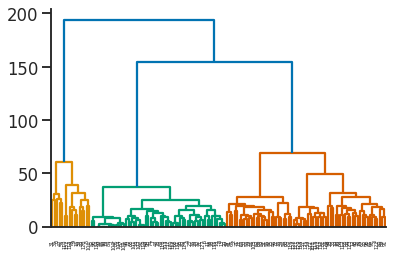

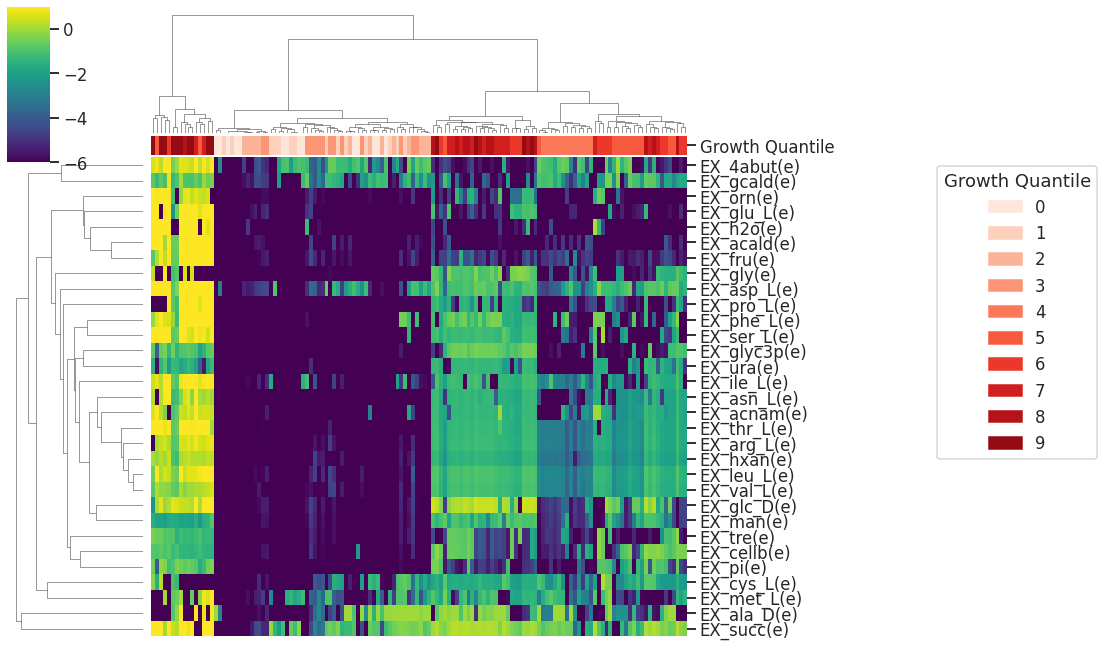

In [24]:
#Make log growth rate heatmap

df=cdiff_import.copy()

max_d =150
X=df.iloc[:,:-7]
Z = linkage(X, 'ward')
dendro = dendrogram(Z,color_threshold=max_d)
clusters = fcluster(Z, max_d, criterion='distance')
colors=sns.color_palette('colorblind',len(pd.unique(clusters)))
cmap={i:colors[i-1] for i in pd.unique(clusters)}

n=10
df['Growth Quantile']=pd.qcut(df.log_growth,n,labels=False)
df.index=df['sample']
colors=sns.color_palette('Reds',n)
cmap = {}
i = 0
for group in sorted(df['Growth Quantile'].unique()):
    cmap[group] = colors[i]
    i+=1
#Use color dictionary to map color to speces column (provides color of each data point)
col_colors=df['Growth Quantile'].copy()
col_colors=col_colors.map(cmap)
idx=df.var()[:-6][df.var()[:-6]>=4.5].index
hits=idx
clust=sns.clustermap(df.iloc[:,:-6][idx].T,cmap='viridis',vmin=-6,vmax=1,figsize=(12,12),col_linkage=Z,col_colors=col_colors,yticklabels=1)
order=[x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])
#Create custom legend to include in plot 
handles = []
labels = sorted(df['Growth Quantile'].unique())
for i in range(len(sorted(labels))):
    patch = mpatches.Patch(color=colors[i],label=labels[i])
    handles.append(patch)  
clust.ax_heatmap.legend(handles=handles,bbox_to_anchor=(1.45,1),loc=2,title='Growth Quantile')
order=clust.data2d.columns
#plt.savefig('Cdiff-FMT-ImportHeatmap-v2.pdf',bbox_inches='tight')

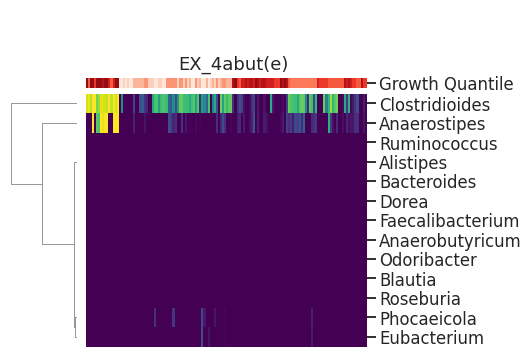

<Figure size 432x288 with 0 Axes>

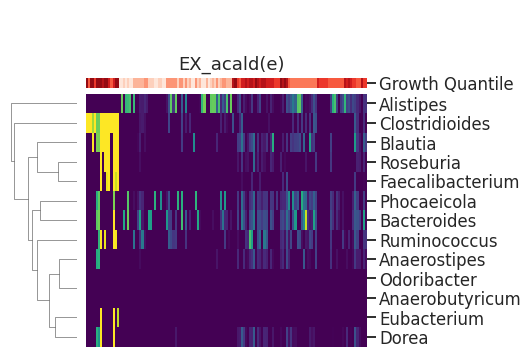

<Figure size 432x288 with 0 Axes>

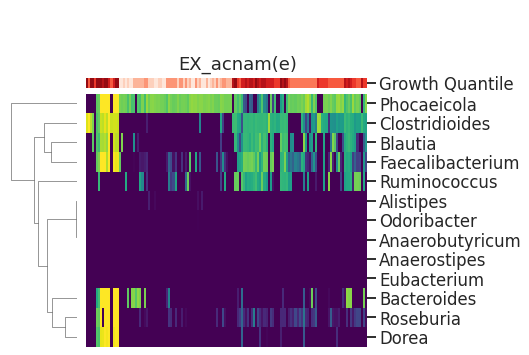

<Figure size 432x288 with 0 Axes>

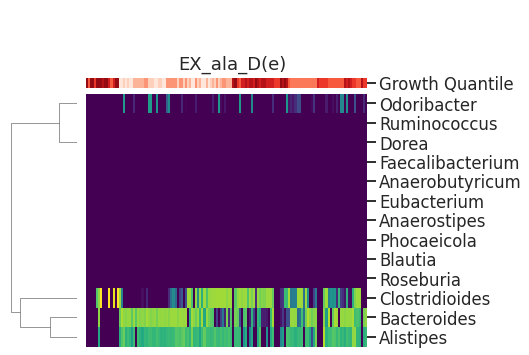

<Figure size 432x288 with 0 Axes>

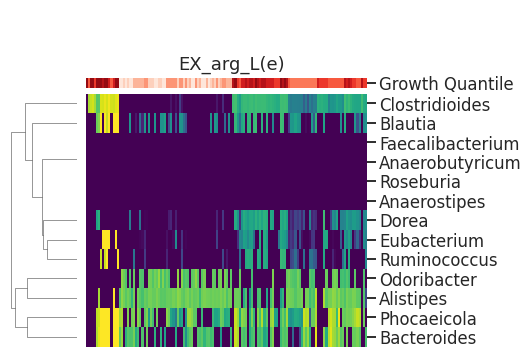

<Figure size 432x288 with 0 Axes>

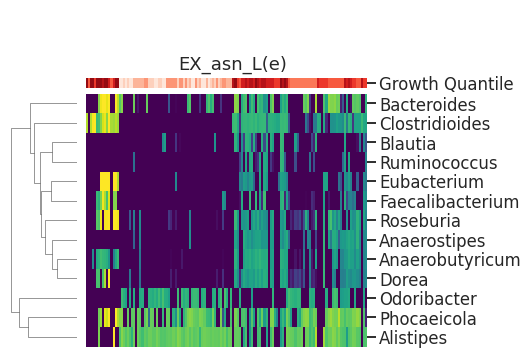

<Figure size 432x288 with 0 Axes>

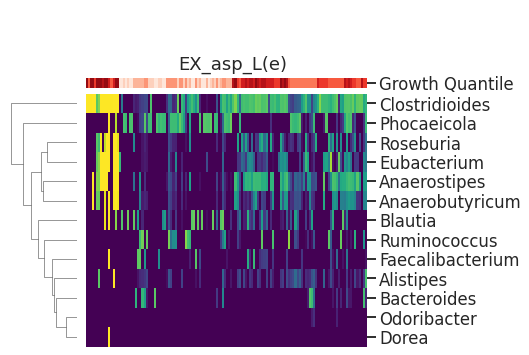

<Figure size 432x288 with 0 Axes>

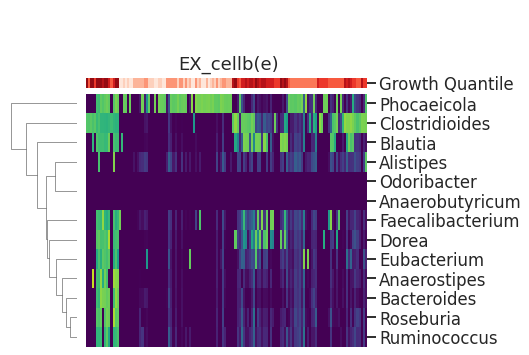

<Figure size 432x288 with 0 Axes>

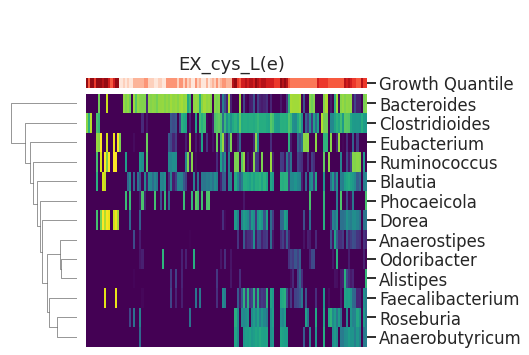

<Figure size 432x288 with 0 Axes>

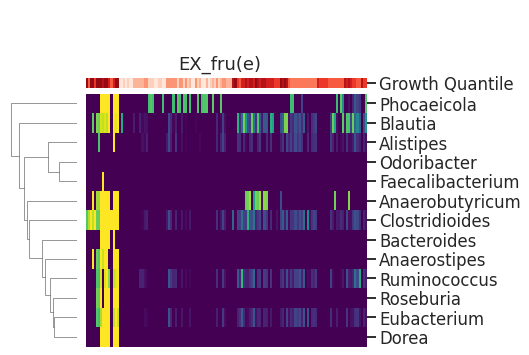

<Figure size 432x288 with 0 Axes>

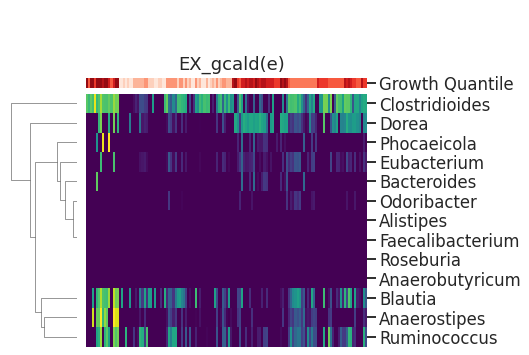

<Figure size 432x288 with 0 Axes>

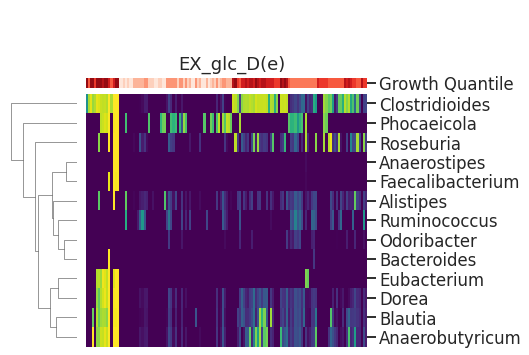

<Figure size 432x288 with 0 Axes>

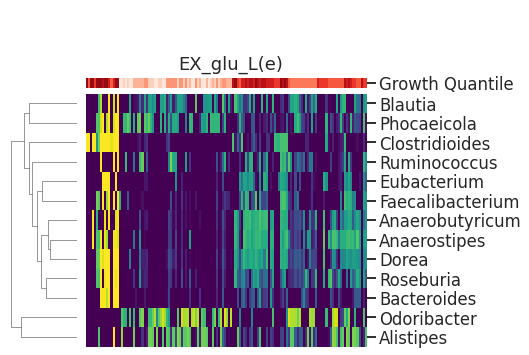

<Figure size 432x288 with 0 Axes>

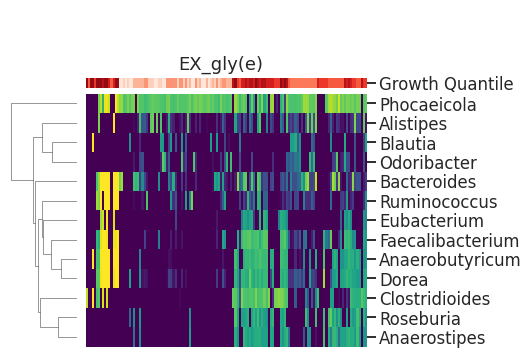

<Figure size 432x288 with 0 Axes>

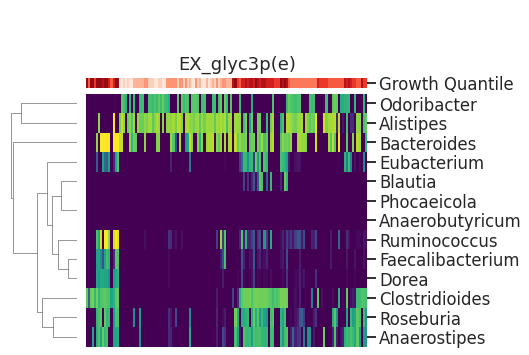

<Figure size 432x288 with 0 Axes>

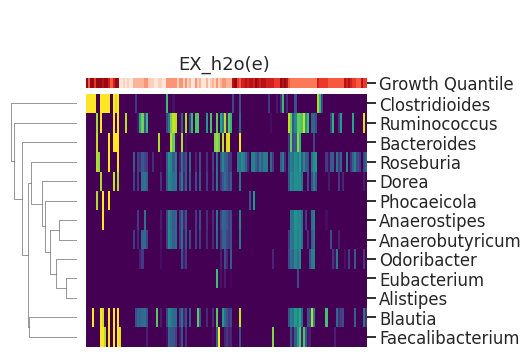

<Figure size 432x288 with 0 Axes>

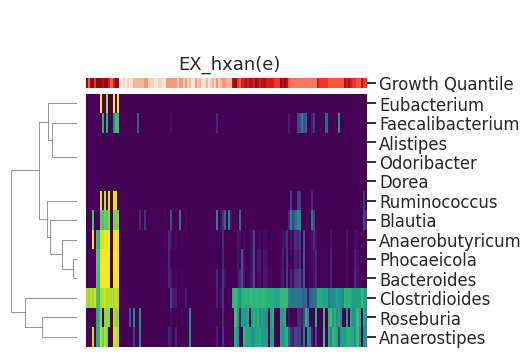

<Figure size 432x288 with 0 Axes>

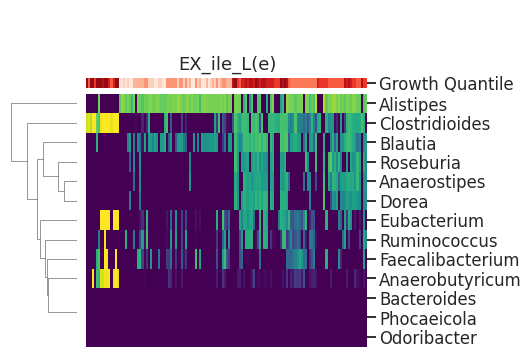

<Figure size 432x288 with 0 Axes>

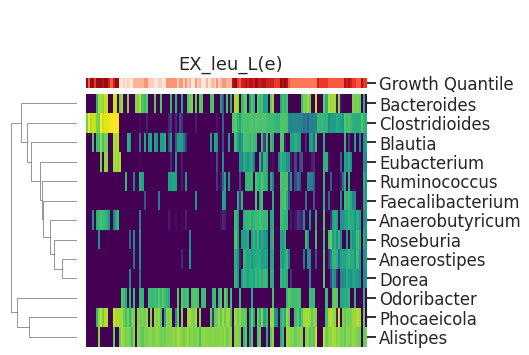

<Figure size 432x288 with 0 Axes>

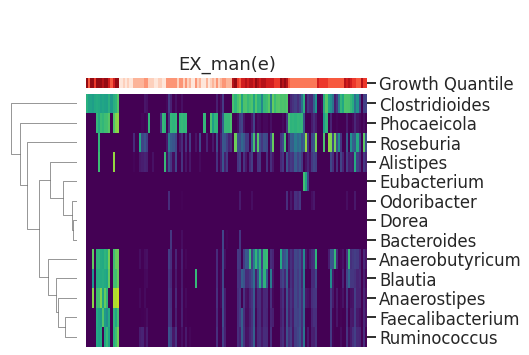

<Figure size 432x288 with 0 Axes>

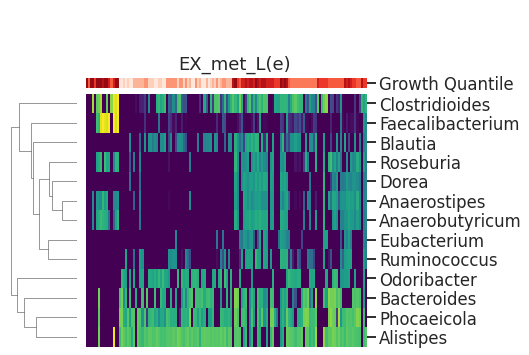

<Figure size 432x288 with 0 Axes>

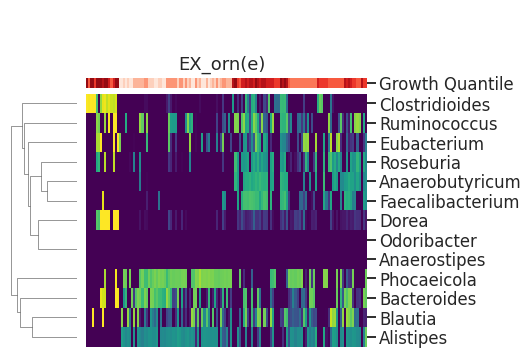

<Figure size 432x288 with 0 Axes>

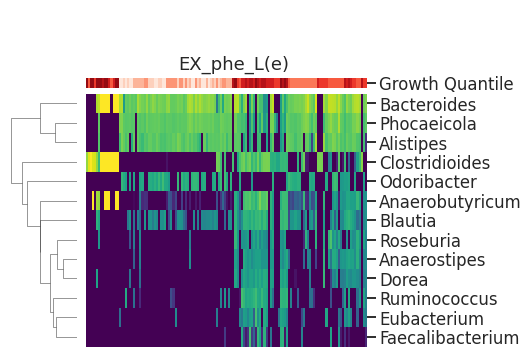

<Figure size 432x288 with 0 Axes>

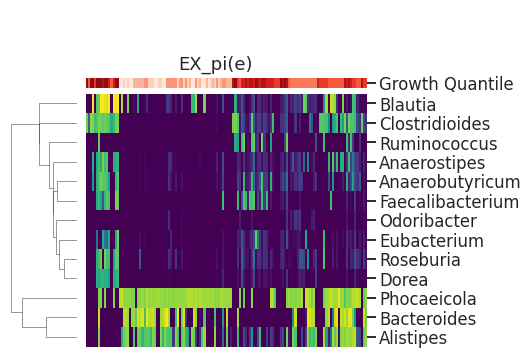

<Figure size 432x288 with 0 Axes>

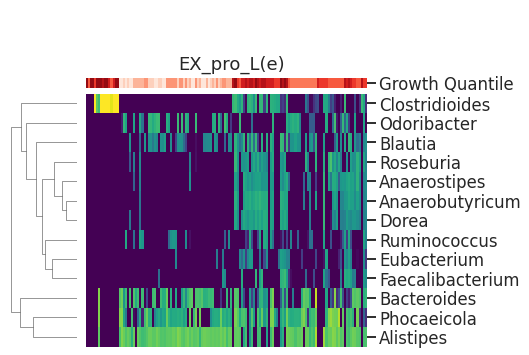

<Figure size 432x288 with 0 Axes>

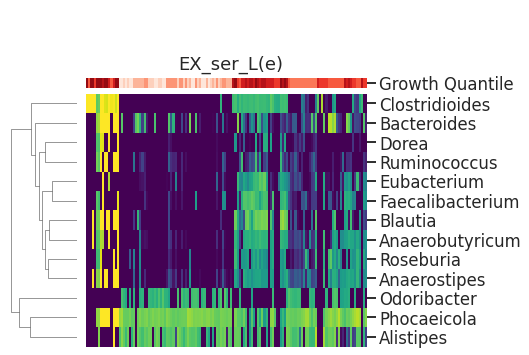

<Figure size 432x288 with 0 Axes>

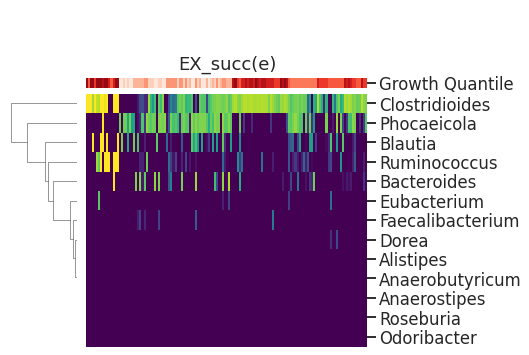

<Figure size 432x288 with 0 Axes>

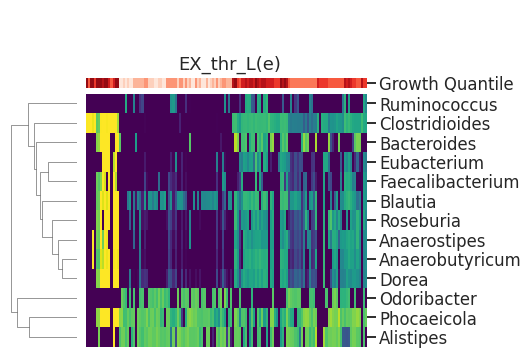

<Figure size 432x288 with 0 Axes>

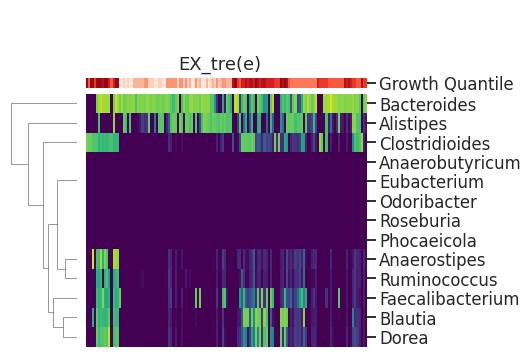

<Figure size 432x288 with 0 Axes>

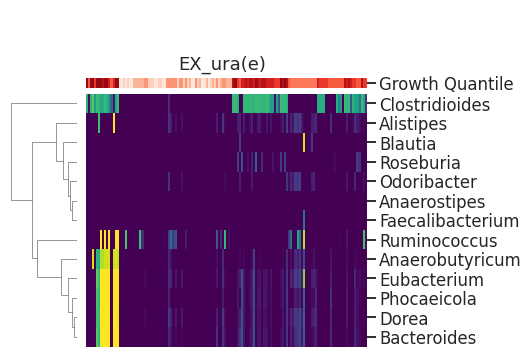

<Figure size 432x288 with 0 Axes>

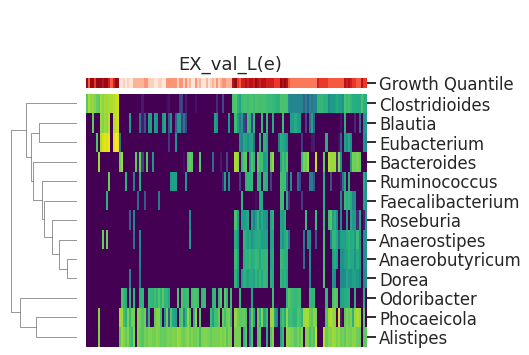

<Figure size 432x288 with 0 Axes>

In [56]:
for flx in hits:
    com_flx=import_flux[flx]
    com_flux=com_flx.reset_index()
    com_flux=com_flux.pivot(index='level_0',columns='level_1',values=flx)
    com_flux[com_flux<-6]=-6
    com_flux=com_flux.fillna(-6)
    com_flux['cluster']=clusters
    com_flux=com_flux=com_flux.sort_values(by='cluster')
    com_flux.drop('cluster',inplace=True,axis=1)
    genera=['Clostridioides','Blautia','Roseburia','Phocaeicola','Odoribacter','Anaerostipes','Eubacterium','Anaerobutyricum','Faecalibacterium','Dorea','Bacteroides','Alistipes','Ruminococcus']
    #cols=com_flux.columns[com_flux.mean()>-5]
    #if len(cols) < 3:
    #    continue
    clust=sns.clustermap(com_flux.loc[order,genera].T,cmap='viridis',vmin=-6,vmax=1,figsize=(8,8),col_linkage=Z,col_colors=col_colors,col_cluster=False)
    clust.ax_heatmap.set_ylabel('')
    clust.ax_heatmap.set_xlabel('')
    clust.ax_heatmap.set_xticks([])
    clust.cax.set_visible(False)
    clust.ax_heatmap.text(45,-1.25,flx)
    #plt.savefig('Comm-import-%s-v2.pdf'%(flx),bbox_inches='tight')
    plt.show()
    plt.clf()

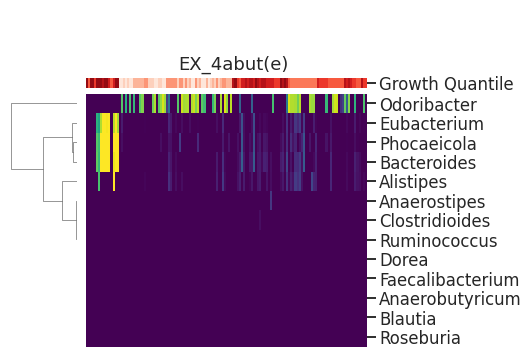

<Figure size 432x288 with 0 Axes>

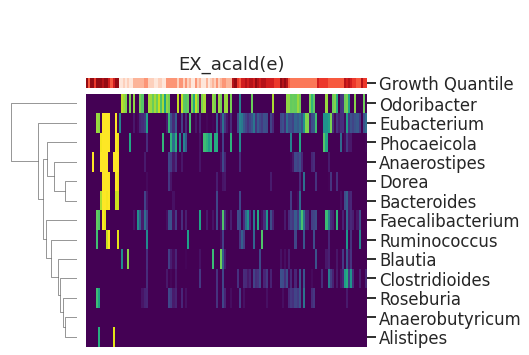

<Figure size 432x288 with 0 Axes>

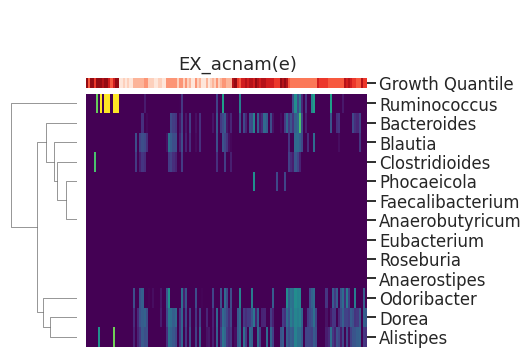

<Figure size 432x288 with 0 Axes>

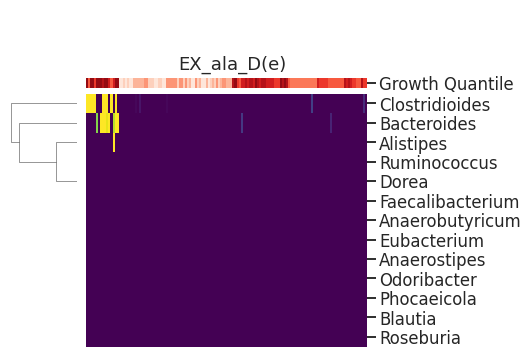

<Figure size 432x288 with 0 Axes>

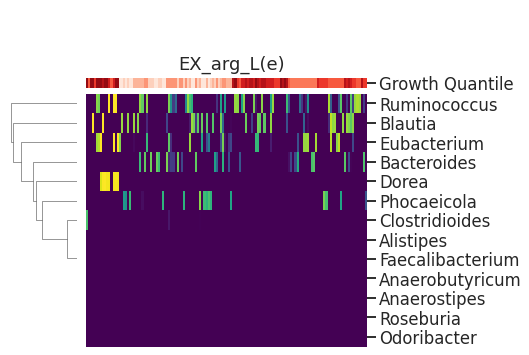

<Figure size 432x288 with 0 Axes>

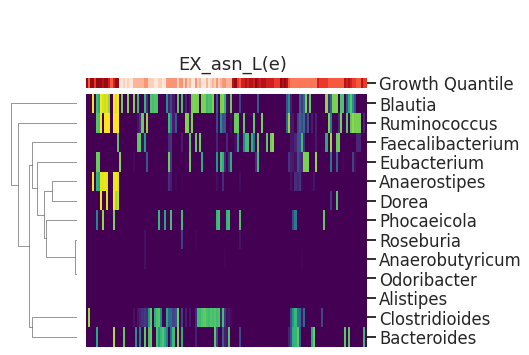

<Figure size 432x288 with 0 Axes>

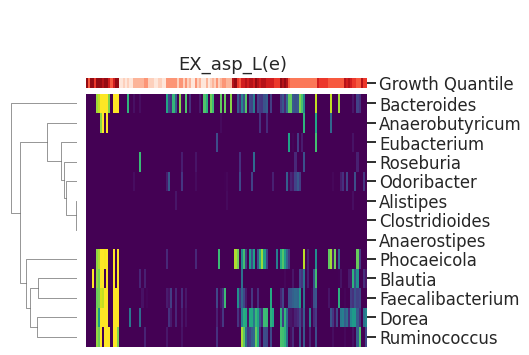

<Figure size 432x288 with 0 Axes>

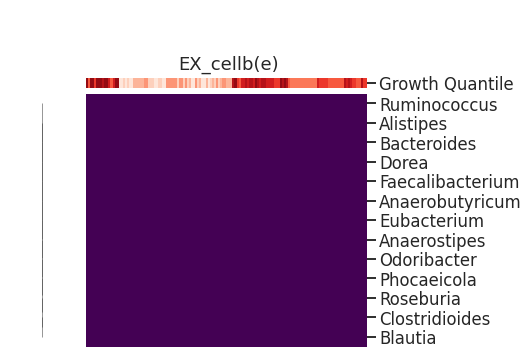

<Figure size 432x288 with 0 Axes>

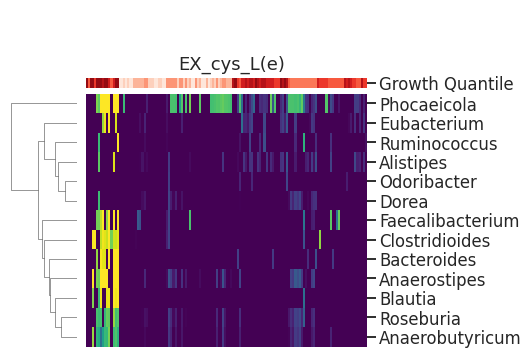

<Figure size 432x288 with 0 Axes>

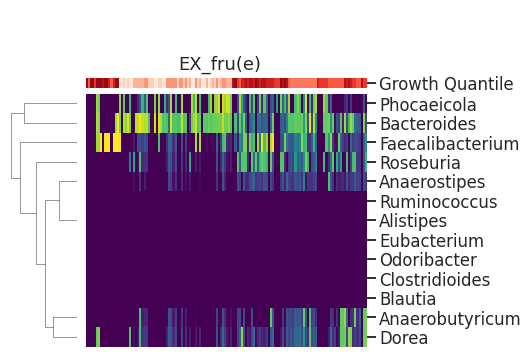

<Figure size 432x288 with 0 Axes>

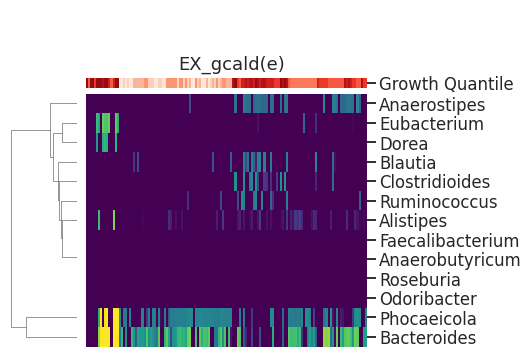

<Figure size 432x288 with 0 Axes>

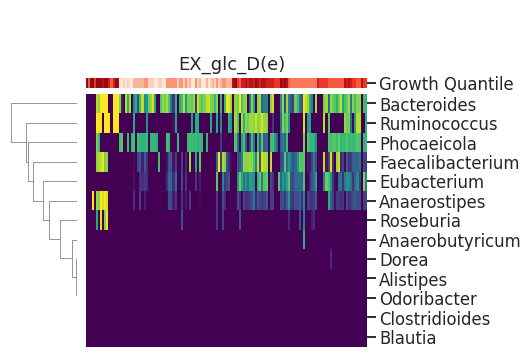

<Figure size 432x288 with 0 Axes>

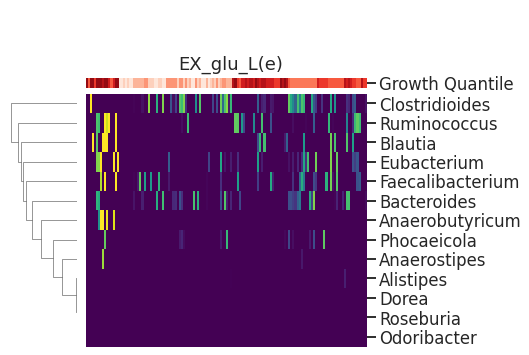

<Figure size 432x288 with 0 Axes>

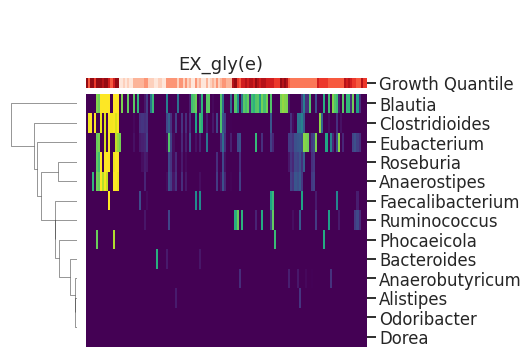

<Figure size 432x288 with 0 Axes>

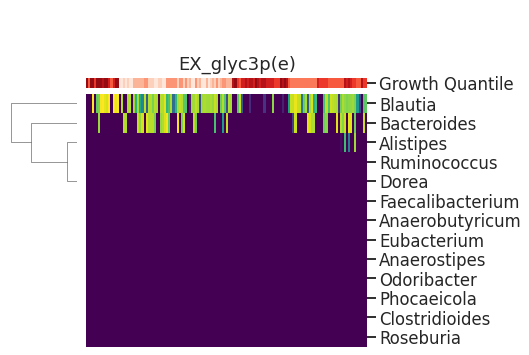

<Figure size 432x288 with 0 Axes>

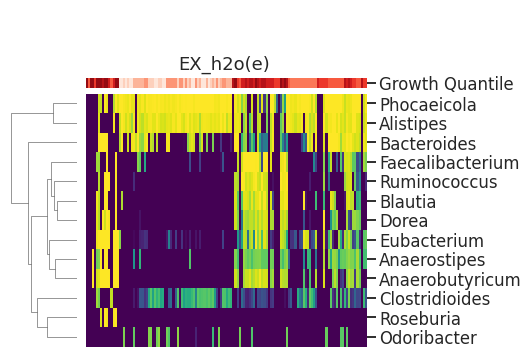

<Figure size 432x288 with 0 Axes>

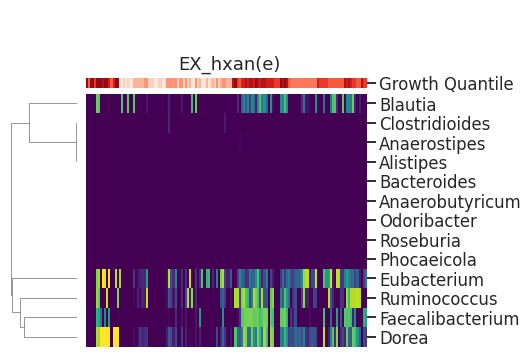

<Figure size 432x288 with 0 Axes>

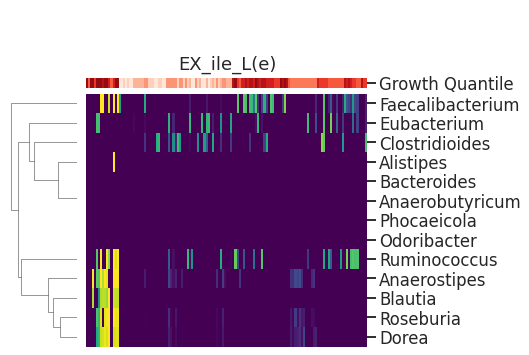

<Figure size 432x288 with 0 Axes>

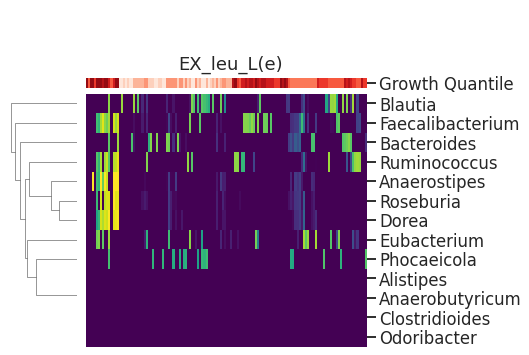

<Figure size 432x288 with 0 Axes>

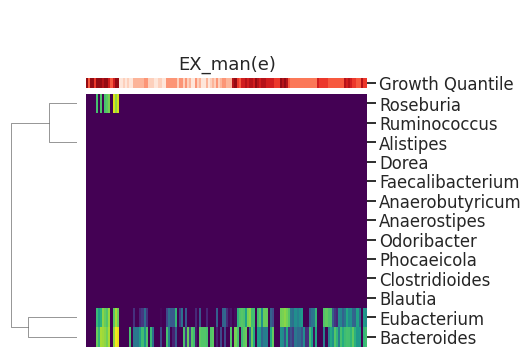

<Figure size 432x288 with 0 Axes>

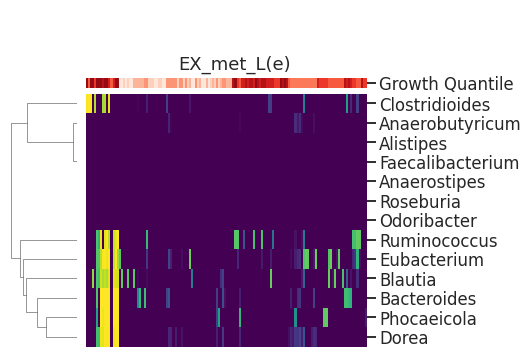

<Figure size 432x288 with 0 Axes>

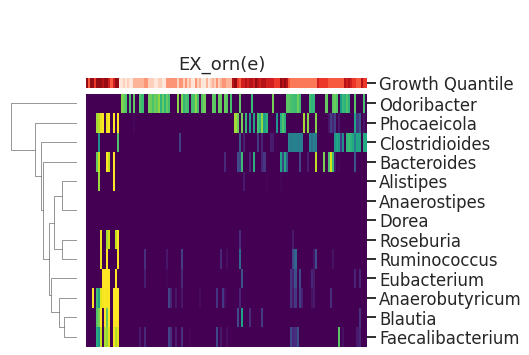

<Figure size 432x288 with 0 Axes>

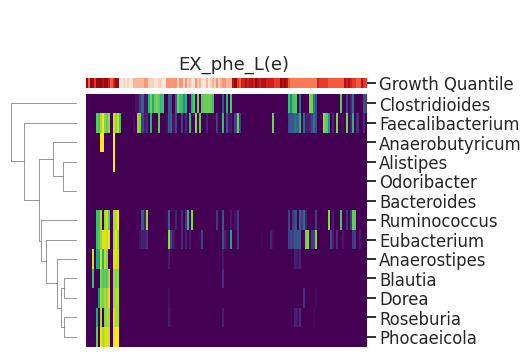

<Figure size 432x288 with 0 Axes>

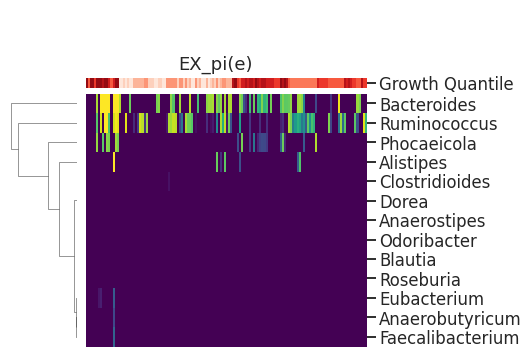

<Figure size 432x288 with 0 Axes>

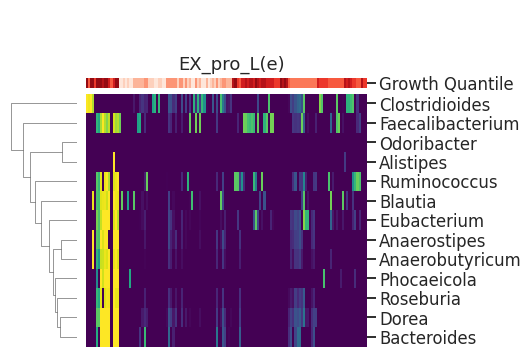

<Figure size 432x288 with 0 Axes>

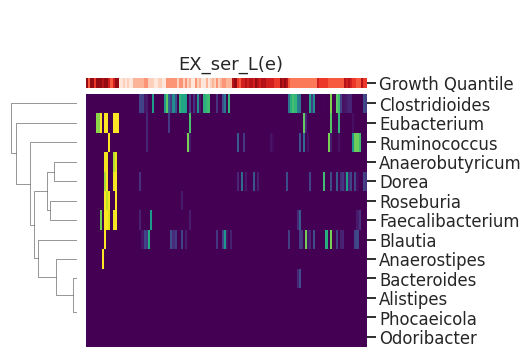

<Figure size 432x288 with 0 Axes>

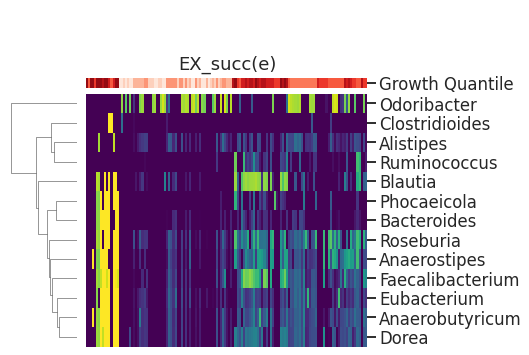

<Figure size 432x288 with 0 Axes>

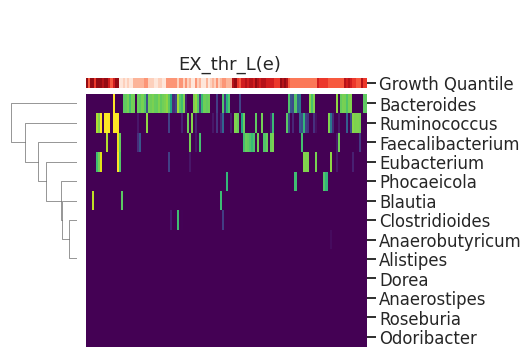

<Figure size 432x288 with 0 Axes>

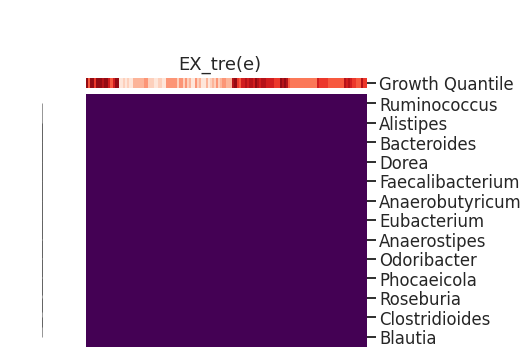

<Figure size 432x288 with 0 Axes>

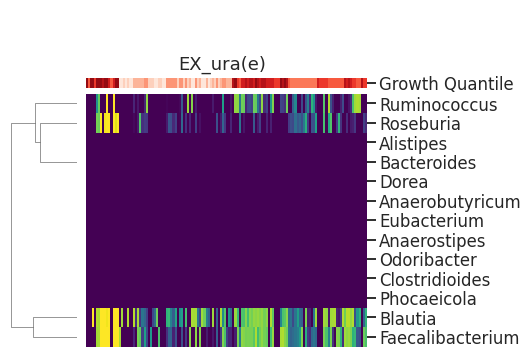

<Figure size 432x288 with 0 Axes>

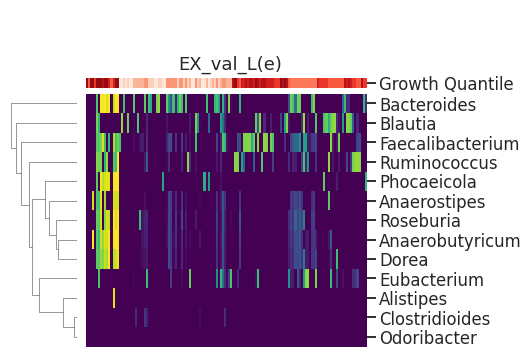

<Figure size 432x288 with 0 Axes>

In [58]:
for flx in hits:
    com_flx=export_flux[flx]
    com_flux=com_flx.reset_index()
    com_flux=com_flux.pivot(index='level_0',columns='level_1',values=flx)
    com_flux[com_flux<-6]=-6
    com_flux=com_flux.fillna(-6)
    com_flux['cluster']=clusters
    com_flux=com_flux=com_flux.sort_values(by='cluster')
    com_flux.drop('cluster',inplace=True,axis=1)
    #cols=com_flux.columns[com_flux.mean()>-5]
    #if len(cols) < 3:
    #    continue
    clust=sns.clustermap(com_flux.loc[order,genera].T,cmap='viridis',vmin=-6,vmax=1,figsize=(8,8),col_linkage=Z,col_colors=col_colors,col_cluster=False)
    clust.ax_heatmap.set_ylabel('')
    clust.ax_heatmap.set_xlabel('')
    clust.ax_heatmap.set_xticks([])
    clust.cax.set_visible(False)
    clust.ax_heatmap.text(45,-1.25,flx)
    #plt.savefig('Comm-export-%s-v2.pdf'%(flx),bbox_inches='tight')
    plt.show()
    plt.clf()